In [33]:
#Question 1(b.i)
#Load the csv file into a dataframe
import pandas as pd
input_df = pd.read_csv("hw2_question1.csv")

#Number of samples belonging to benign and number belonging to malignant case
num_samples_benign = input_df.loc[input_df['Class'] == 2].shape
print("Number of benign samples: ",num_samples_benign)

num_samples_malignant = input_df.loc[input_df['Class'] == 4].shape
print("Number of malignant samples: ",num_samples_malignant)

#The two classes percentage distribution
#Benign: 65%
#Malignant: 35%

Number of benign samples:  (444, 10)
Number of malignant samples:  (239, 10)


In [28]:
#Randomly shuffle the data and divide into train and test sets
#2/3rd training data
#1/3rd testing data
from sklearn.utils import shuffle
benign_samples = input_df.loc[input_df['Class'] == 2]
benign_samples = shuffle(benign_samples)

benign_train = benign_samples.iloc[0:296,:]
benign_test = benign_samples.iloc[296:,:]

malign_samples = input_df.loc[input_df['Class'] == 4]
malign_samples = shuffle(malign_samples)

malign_train = malign_samples.iloc[0:159,:]
malign_test = malign_samples.iloc[159:,:]

train_set = pd.concat([benign_train, malign_train])
X_train = train_set.iloc[:,0:9]
Y_train = train_set.iloc[:,-1]
print("X_train:",X_train.shape)
print("Y_train:",Y_train.shape)

test_set = pd.concat([benign_test , malign_test])
X_test = test_set.iloc[:,0:9]
Y_test = test_set.iloc[:,-1]
print("X_test:",X_test.shape)
print("Y_test:",Y_test.shape)

X_train: (455, 9)
Y_train: (455,)
X_test: (228, 9)
Y_test: (228,)


In [3]:
import math
import sys
#Function computes entropy given a feature
#input is an array containing different feature values
def computeBranchEntropy(feature_values):
    total = feature_values.shape[0]
    num_benign = len(feature_values.index[feature_values == 2].tolist())
    if(num_benign == 0 or num_benign == total):
        return 0.0
    num_malign = len(feature_values.index[feature_values == 4].tolist())
    entropy = (num_benign)/(total) * math.log2(num_benign/total) + \
                 ((num_malign)/(total))* math.log2(num_malign/total)
    entropy = entropy*(-1)
    return entropy

In [4]:
#Input is a dataframe which corresponds to values of a feature.
#Considers 9 possible splits of input features 
#and returns the split which gives minimum entropy
def computeConditionalEntropy(feature_df):
    min_entropy = sys.maxsize
    min_split_index = -1
    for i in range(1,10):
        branch_1 = feature_df.index[feature_df <= i]
        branch_2 = feature_df.index[feature_df > i]
        branch_1_values = Y_train.loc[branch_1]
        branch_2_values = Y_train.loc[branch_2]
        branch_1_num = branch_1_values.shape[0]
        branch_2_num = branch_2_values.shape[0]
        if(branch_1_num !=0 or branch_2_num != 0):
            branch_1_entropy = computeBranchEntropy(branch_1_values)
            branch_2_entropy = computeBranchEntropy(branch_2_values)
            total = branch_1_num + branch_2_num
            entropy_split = (branch_1_num/total)*(branch_1_entropy) \
                            + (branch_2_num/total)*(branch_2_entropy)
            if(entropy_split < min_entropy):
                min_entropy = entropy_split
                min_split_index = i
    return (min_entropy, min_split_index)

In [5]:
#Function which gives the attribute for which
#the entropy is minimum
#Also gives the range at which that particular attribute 
#has to be split
def SplitAttribute(train_set):
    min_entropy = sys.maxsize
    min_attribute = -1
    min_attribute_split = -1
    for i in train_set:
        if (i != 'Class' and train_set.loc[:,i].shape[0] != 0):
            (cond_entropy, index) = computeConditionalEntropy(train_set.loc[:,i])
            if(cond_entropy < min_entropy):
                min_entropy = cond_entropy
                min_attribute = i
                min_attribute_split = index
    return (min_attribute, min_attribute_split, min_entropy)

In [6]:
class Tree:
    def _init_(self):
        self.left = None
        self.right = None
        self.split_index = None
        self.split_attribute = None
        self.type = None
        
root = Tree()
root.data = "root"
root.left = Tree()
root.left.data = "left"
root.right = Tree()
root.right.data = "right"

In [7]:
#Generates leaf node based on majority voting
def generateLeaf(train_values):
    num_benign = len(train_values.index[train_values.iloc[:,-1] == 2].tolist())
    num_malign = len(train_values.index[train_values.iloc[:,-1] ==4].tolist())
    root = Tree()
    if(num_benign > num_malign):
        root.type = 2
    else:
        root.type = 4
    return root

In [8]:
#Question 1(b.ii)
#Decision tree with entropy as splitting criteria
#Stop gorwing the tree by conditioning on maximum depth
def GenerateTree(train_set,max_depth,curr_depth):
    if(curr_depth >= max_depth):
        return generateLeaf(train_set)
    else:
        best_attribute, best_index, best_entropy = SplitAttribute(train_set)
        
        left_data = train_set[train_set.loc[:,best_attribute] <= best_index]
        right_data = train_set[train_set.loc[:,best_attribute] > best_index]
        
        #left_data = left_data.drop(best_attribute,axis=1)
        #right_data = right_data.drop(best_attribute,axis=1)
    
        if(left_data.shape[0] == 0 or left_data.shape[0] == train_set.shape[0]):
            return generateLeaf(train_set)
        root = Tree()
        root.split_index = best_index
        root.split_attribute = best_attribute
        root.left = GenerateTree(left_data,max_depth,curr_depth+1)
        root.right = GenerateTree(right_data,max_depth,curr_depth+1)
        return root

In [9]:
#Predicts the class of a sample
def predictSample(root, sample_row):
    if hasattr(root,'split_attribute'):
        #this is a non-leaf node
        if(sample_row[root.split_attribute] <= root.split_index):
            return predictSample(root.left, sample_row)
        else:
            return predictSample(root.right,sample_row)
    else:
        return root.type
    
def predict(root,train_set):
    train_len = train_set.shape[0]
    correct_labels = 0
    for i in range(train_len):
        train_row = train_set.iloc[i,:]
        predicted_label = predictSample(root,train_row)
        actual_label = train_set.iloc[i,-1]
        if(predicted_label == actual_label):
            correct_labels = correct_labels + 1
    return (correct_labels/train_len)
    

In [29]:
#Iterate over the training and testing set
#and report accuracy as the number of nodes increase
accuracylist_train = []
accuracylist_test = []
depth_tree = []
for i in range(1,10):
    depth_tree.append(i)
    root = GenerateTree(train_set,i,0)
    accuracy_train = predict(root,train_set)
    accuracy_test = predict(root,test_set)
    print("Number of levels in tree: ",i)
    print("Accuracy on training set: ",accuracy_train)
    print("Accuracy on testing set: ",accuracy_test)
    accuracylist_train.append(accuracy_train)
    accuracylist_test.append(accuracy_test)

Number of levels in tree:  1
Accuracy on training set:  0.9208791208791208
Accuracy on testing set:  0.9035087719298246
Number of levels in tree:  2
Accuracy on training set:  0.9230769230769231
Accuracy on testing set:  0.9078947368421053
Number of levels in tree:  3
Accuracy on training set:  0.978021978021978
Accuracy on testing set:  0.9429824561403509
Number of levels in tree:  4
Accuracy on training set:  0.9824175824175824
Accuracy on testing set:  0.9473684210526315
Number of levels in tree:  5
Accuracy on training set:  0.9846153846153847
Accuracy on testing set:  0.9429824561403509
Number of levels in tree:  6
Accuracy on training set:  0.9868131868131869
Accuracy on testing set:  0.9429824561403509
Number of levels in tree:  7
Accuracy on training set:  0.9912087912087912
Accuracy on testing set:  0.9385964912280702
Number of levels in tree:  8
Accuracy on training set:  0.9934065934065934
Accuracy on testing set:  0.9429824561403509
Number of levels in tree:  9
Accuracy on 

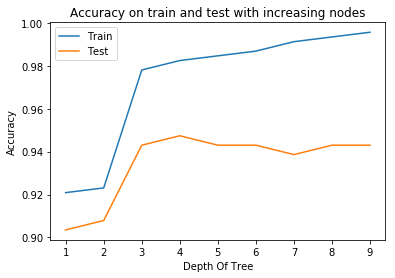

In [30]:
#plot accuracy for training and testing data
import matplotlib.pyplot as plt
import numpy as np

plt.plot(depth_tree, accuracylist_train, label='Train')
plt.plot(depth_tree, accuracylist_test, label ='Test')
plt.title('Accuracy on train and test with increasing nodes')
plt.xlabel('Depth Of Tree')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [13]:
#Question 1(b.ii)
#Gini Index as splitting criterion
#Function to compute Gini index
def computeGiniIndex(feature_values):
    total = feature_values.shape[0]
    num_benign = len(feature_values.index[feature_values == 2].tolist())
    if(num_benign == 0 or num_benign == total):
        return 0.0
    num_malign = len(feature_values.index[feature_values == 4].tolist())
    p1 = (num_benign)/(total)
    giniIndex = 2*p1*(1-p1)
    return giniIndex
    

In [14]:
#Find the best split using gini Index
def best_split_giniIndex(feature_df):
    min_gini = sys.maxsize
    min_split_index = 0
    for i in range(1,10):
        branch_1 = feature_df.index[feature_df <= i]
        branch_2 = feature_df.index[feature_df > i]
        branch_1_values = Y_train.loc[branch_1]
        branch_2_values = Y_train.loc[branch_2]
        branch_1_num = branch_1_values.shape[0]
        branch_2_num = branch_2_values.shape[0]
        if(branch_1_num !=0 or branch_2_num != 0):
            branch_1_giniIndex = computeGiniIndex(branch_1_values)
            branch_2_giniIndex = computeGiniIndex(branch_2_values)
            total = branch_1_num + branch_2_num
            gini_split = (branch_1_num/total)*(branch_1_giniIndex) + \
                            (branch_2_num/total)*(branch_2_giniIndex)
            if(gini_split < min_gini):
                min_gini = gini_split
                min_split_index = i
    return (min_gini, min_split_index)

In [15]:
def best_split_attribute_gini(train_set):
    min_gini = sys.maxsize
    min_attribute = -1
    min_attribute_split = -1
    for i in train_set:
        if (i != 'Class' and train_set.loc[:,i].shape[0] != 0):
            (gini, index) = best_split_giniIndex(train_set.loc[:,i])
            if(gini < min_gini):
                min_gini = gini
                min_attribute = i
                min_attribute_split = index
    return (min_attribute, min_attribute_split, min_gini)

In [16]:
#Decision tree with gini index as splitting criterion
def GenerateTree_gini(train_set,max_depth,curr_depth):
    if(curr_depth >= max_depth):
        return generateLeaf(train_set)
    else:
        best_attribute, best_index, best_gini = best_split_attribute_gini(train_set)
        left_data = train_set[train_set.loc[:,best_attribute] <= best_index]
        right_data = train_set[train_set.loc[:,best_attribute] > best_index]
        
        #left_data = left_data.drop(best_attribute,axis=1)
        #right_data = right_data.drop(best_attribute,axis=1)
        
        if(left_data.shape[0] == 0 or left_data.shape[0] == train_set.shape[0]):
            return generateLeaf(train_set)
        
        root = Tree()
        root.split_index = best_index
        root.split_attribute = best_attribute
        root.left = GenerateTree_gini(left_data,max_depth,curr_depth+1)
        root.right = GenerateTree_gini(right_data,max_depth,curr_depth+1)
        return root


In [31]:
#Accuracy on train and test sets with increasing 
#number of nodes and gini index as splitting criterion
accuracylist_train = []
accuracylist_test = []
depth_tree = []
for i in range(1,10):
    depth_tree.append(i)
    root = GenerateTree_gini(train_set,i,0)
    accuracy_train = predict(root,train_set)
    accuracy_test = predict(root,test_set)
    print("Number of levels in the tree :",i)
    print("Accuracy on the training set: ",accuracy_train)
    print("Accuracy on the testing set: ",accuracy_test)
    accuracylist_train.append(accuracy_train)
    accuracylist_test.append(accuracy_test)

Number of levels in the tree : 1
Accuracy on the training set:  0.9406593406593406
Accuracy on the testing set:  0.8947368421052632
Number of levels in the tree : 2
Accuracy on the training set:  0.967032967032967
Accuracy on the testing set:  0.9385964912280702
Number of levels in the tree : 3
Accuracy on the training set:  0.9714285714285714
Accuracy on the testing set:  0.9385964912280702
Number of levels in the tree : 4
Accuracy on the training set:  0.978021978021978
Accuracy on the testing set:  0.9385964912280702
Number of levels in the tree : 5
Accuracy on the training set:  0.9868131868131869
Accuracy on the testing set:  0.9298245614035088
Number of levels in the tree : 6
Accuracy on the training set:  0.989010989010989
Accuracy on the testing set:  0.9298245614035088
Number of levels in the tree : 7
Accuracy on the training set:  0.9956043956043956
Accuracy on the testing set:  0.9385964912280702
Number of levels in the tree : 8
Accuracy on the training set:  0.9978021978021

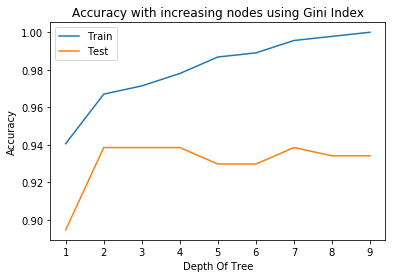

In [32]:
#plot accuracy for training data
import matplotlib.pyplot as plt
import numpy as np

plt.plot(depth_tree, accuracylist_train, label='Train')
plt.plot(depth_tree, accuracylist_test, label ='Test')
plt.xlabel('Depth Of Tree')
plt.ylabel('Accuracy')
plt.title('Accuracy with increasing nodes using Gini Index')
plt.legend()
plt.show()

In [19]:
#Question 1(b.iii)
#Bonus part: Implement Prepruning by keeping a threshold on 
#the number of training samples
def GenerateTree_threshold_samples(train_set,max_depth,curr_depth,min_samples):
    if(curr_depth >= max_depth or train_set.shape[0] < min_samples):
        return generateLeaf(train_set)
    else:
        best_attribute, best_index, best_entropy = SplitAttribute(train_set)
        
        left_data = train_set[train_set.loc[:,best_attribute] <= best_index]
        right_data = train_set[train_set.loc[:,best_attribute] > best_index]
        
        #left_data = left_data.drop(best_attribute,axis=1)
        #right_data = right_data.drop(best_attribute,axis=1)
    
        if(left_data.shape[0] == 0 or left_data.shape[0] == train_set.shape[0]):
            return generateLeaf(train_set)
        root = Tree()
        root.split_index = best_index
        root.split_attribute = best_attribute
        root.left = GenerateTree_threshold_samples(left_data,max_depth,curr_depth+1 \
                                                   ,min_samples)
        root.right = GenerateTree_threshold_samples(right_data,max_depth,curr_depth+1, \
                                                    min_samples)
        return root

In [20]:
#Depth of tree considered = 9
#minimum number of training samples has been considered as stopping criterion
accuracylist_train = []
accuracylist_test = []
thresholds = [10, 20, 30, 40, 50, 60, 70, 80]
for i in thresholds:
    root = GenerateTree_threshold_samples(train_set,9,0,i)
    accuracy_train = predict(root,train_set)
    accuracy_test = predict(root,test_set)
    print("Minimum number of training samples: ",i)
    print("Accuracy on the training set: ",accuracy_train)
    print("Accuracy on the test set: ",accuracy_test)
    accuracylist_train.append(accuracy_train)
    accuracylist_test.append(accuracy_test)

Minimum number of training samples:  10
Accuracy on the training set:  0.9758241758241758
Accuracy on the test set:  0.9473684210526315
Minimum number of training samples:  20
Accuracy on the training set:  0.9714285714285714
Accuracy on the test set:  0.9473684210526315
Minimum number of training samples:  30
Accuracy on the training set:  0.967032967032967
Accuracy on the test set:  0.9517543859649122
Minimum number of training samples:  40
Accuracy on the training set:  0.9384615384615385
Accuracy on the test set:  0.9254385964912281
Minimum number of training samples:  50
Accuracy on the training set:  0.9384615384615385
Accuracy on the test set:  0.9254385964912281
Minimum number of training samples:  60
Accuracy on the training set:  0.9384615384615385
Accuracy on the test set:  0.9254385964912281
Minimum number of training samples:  70
Accuracy on the training set:  0.9384615384615385
Accuracy on the test set:  0.9254385964912281
Minimum number of training samples:  80
Accuracy 

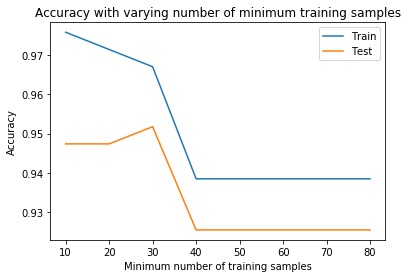

In [21]:
#plot accuracy for training data
import matplotlib.pyplot as plt
import numpy as np

plt.plot(thresholds, accuracylist_train, label='Train')
plt.plot(thresholds, accuracylist_test, label ='Test')
plt.xlabel('Minimum number of training samples')
plt.ylabel('Accuracy')
plt.title('Accuracy with varying number of minimum training samples')
plt.legend()
plt.show()

In [22]:
#Pre pruning based on a minimum value of entropy
#Minimum entropy is set as stopping criterion for growing the tree
def GenerateTree_threshold_entropy(train_set,max_depth,curr_depth,min_entropy):
    if(curr_depth >= max_depth):
        return generateLeaf(train_set)
    else:
        best_attribute, best_index, best_entropy = SplitAttribute(train_set)
        if(best_entropy < min_entropy):
            return generateLeaf(train_set)
        
        left_data = train_set[train_set.loc[:,best_attribute] <= best_index]
        right_data = train_set[train_set.loc[:,best_attribute] > best_index]
        
        #left_data = left_data.drop(best_attribute,axis=1)
        #right_data = right_data.drop(best_attribute,axis=1)
        
        #check for no split
        if(left_data.shape[0] == 0 or right_data.shape[0] == 0):
            return generateLeaf(train_set)
        
        root = Tree()
        root.split_index = best_index
        root.split_attribute = best_attribute
    
        root.left = GenerateTree_threshold_entropy(left_data,max_depth,curr_depth+1, \
                                                   min_entropy)
        root.right = GenerateTree_threshold_entropy(right_data,max_depth,curr_depth+1,\
                                                    min_entropy)
        return root
    

In [23]:
#Various entropy values are considered as thresholds
accuracylist_train = []
accuracylist_test = []
entropy_thresholds = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
for i in entropy_thresholds:
    root = GenerateTree_threshold_entropy(train_set,9,0,i)
    accuracy_train = predict(root,train_set)
    accuracy_test = predict(root,test_set)
    print("Minimum entropy threshold: ",i)
    print("Accuracy on the training set: ",accuracy_train)
    print("Accuracy on the testing set: ",accuracy_test)
    accuracylist_train.append(accuracy_train)
    accuracylist_test.append(accuracy_test)

Minimum entropy threshold:  0.0
Accuracy on the training set:  1.0
Accuracy on the testing set:  0.956140350877193
Minimum entropy threshold:  0.05
Accuracy on the training set:  0.9846153846153847
Accuracy on the testing set:  0.956140350877193
Minimum entropy threshold:  0.1
Accuracy on the training set:  0.9714285714285714
Accuracy on the testing set:  0.9605263157894737
Minimum entropy threshold:  0.15
Accuracy on the training set:  0.9692307692307692
Accuracy on the testing set:  0.9605263157894737
Minimum entropy threshold:  0.2
Accuracy on the training set:  0.9692307692307692
Accuracy on the testing set:  0.9605263157894737
Minimum entropy threshold:  0.25
Accuracy on the training set:  0.9626373626373627
Accuracy on the testing set:  0.9649122807017544
Minimum entropy threshold:  0.3
Accuracy on the training set:  0.9626373626373627
Accuracy on the testing set:  0.9649122807017544
Minimum entropy threshold:  0.35
Accuracy on the training set:  0.9538461538461539
Accuracy on th

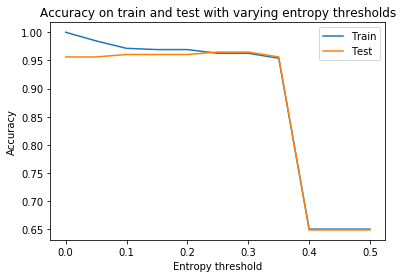

In [24]:
#plot accuracy for training data
import matplotlib.pyplot as plt
import numpy as np

plt.plot(entropy_thresholds, accuracylist_train, label='Train')
plt.plot(entropy_thresholds, accuracylist_test, label ='Test')
plt.xlabel('Entropy threshold')
plt.title('Accuracy on train and test with varying entropy thresholds')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [34]:
#Pre pruning based on a minimum value of giniIndex
#Minimum gini index is set as stopping criterion for growing the tree
def GenerateTree_threshold_gini(train_set,max_depth,curr_depth,min_gini):
    if(curr_depth >= max_depth):
        return generateLeaf(train_set)
    else:
        best_attribute, best_index, best_gini = best_split_attribute_gini(train_set)
        if(best_gini < min_gini):
            return generateLeaf(train_set)
        
        left_data = train_set[train_set.loc[:,best_attribute] <= best_index]
        right_data = train_set[train_set.loc[:,best_attribute] > best_index]
        
        #left_data = left_data.drop(best_attribute,axis=1)
        #right_data = right_data.drop(best_attribute,axis=1)
        
        #check for no split
        if(left_data.shape[0] == 0 or right_data.shape[0] == 0):
            return generateLeaf(train_set)
        
        root = Tree()
        root.split_index = best_index
        root.split_attribute = best_attribute
    
        root.left = GenerateTree_threshold_gini(left_data,max_depth,curr_depth+1, \
                                                   min_gini)
        root.right = GenerateTree_threshold_gini(right_data,max_depth,curr_depth+1,\
                                                    min_gini)
        return root
    

In [35]:
#Various gini index values are considered as thresholds
accuracylist_train = []
accuracylist_test = []
gini_thresholds = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
for i in gini_thresholds:
    root = GenerateTree_threshold_gini(train_set,9,0,i)
    accuracy_train = predict(root,train_set)
    accuracy_test = predict(root,test_set)
    print("Minimum gini threshold: ",i)
    print("Accuracy on the training set: ",accuracy_train)
    print("Accuracy on the testing set: ",accuracy_test)
    accuracylist_train.append(accuracy_train)
    accuracylist_test.append(accuracy_test)

Minimum gini threshold:  0.0
Accuracy on the training set:  1.0
Accuracy on the testing set:  0.9342105263157895
Minimum gini threshold:  0.05
Accuracy on the training set:  0.9648351648351648
Accuracy on the testing set:  0.8991228070175439
Minimum gini threshold:  0.1
Accuracy on the training set:  0.9472527472527472
Accuracy on the testing set:  0.8991228070175439
Minimum gini threshold:  0.15
Accuracy on the training set:  0.6505494505494506
Accuracy on the testing set:  0.6491228070175439
Minimum gini threshold:  0.2
Accuracy on the training set:  0.6505494505494506
Accuracy on the testing set:  0.6491228070175439
Minimum gini threshold:  0.25
Accuracy on the training set:  0.6505494505494506
Accuracy on the testing set:  0.6491228070175439
Minimum gini threshold:  0.3
Accuracy on the training set:  0.6505494505494506
Accuracy on the testing set:  0.6491228070175439
Minimum gini threshold:  0.35
Accuracy on the training set:  0.6505494505494506
Accuracy on the testing set:  0.6491

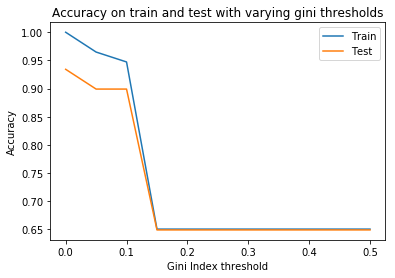

In [36]:
#plot accuracy for training and testing data
import matplotlib.pyplot as plt
import numpy as np

plt.plot(gini_thresholds, accuracylist_train, label='Train')
plt.plot(gini_thresholds, accuracylist_test, label ='Test')
plt.xlabel('Gini Index threshold')
plt.title('Accuracy on train and test with varying gini thresholds')
plt.ylabel('Accuracy')
plt.legend()
plt.show()